In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [4]:
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [5]:
df = pd.read_csv("BostonHousing (1).csv")
df = df.rename(columns={'medv': 'Price'})

In [6]:
df = df.dropna()

In [7]:
class HandlingOutliers:
    """
    A transformer class to handle outliers in specified columns of a DataFrame.

    Parameters:
    -----------
    cols : list, optional
        List of column names to handle outliers. Default is None.
    """

    def __init__(self, cols: list = None):
        """
        Initialize HandlingOutliers class.

        Parameters:
        -----------
        cols : list, optional
            List of column names to handle outliers. Default is None.
        """
        logger.info("Handling Outliers class initialized")
        self.outlier_cols = cols

    def fit(self, X, y=None):
        """
        Fit method required by scikit-learn pipeline. Does nothing.

        Parameters:
        -----------
        X : DataFrame
            Input DataFrame.
        y : None
            Target values. Not used.

        Returns:
        --------
        self
        """
        return self

    def transform(self, X, y=None):
        """
        Transform method to handle outliers in specified columns of the DataFrame.

        Parameters:
        -----------
        X : DataFrame
            Input DataFrame.
        y : None
            Target values. Not used.

        Returns:
        --------
        DataFrame
            Transformed DataFrame after handling outliers in specified columns.
        """
        X = X.copy()

        logger.info(f"Handling Outliers From {self.outlier_cols} Column(s) From DataFrame")
        
        for col in self.outlier_cols:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)

            IQR = Q3 - Q1

            maximum_threshold = Q3 + 1.5 * IQR
            minimum_threshold = Q1 - 1.5 * IQR

            X[col] = np.where(X[col] > maximum_threshold, maximum_threshold,
                              np.where(X[col] < minimum_threshold, minimum_threshold,
                                       X[col]))
    
        logger.info(f"Handling Outliers Complited")
        
        return X
    
    
    

class Standardization:
    """
    A transformer class to standardize specified columns of a DataFrame.

    Parameters:
    -----------
    cols : list, optional
        List of column names to be standardized. Default is None.
    """

    def __init__(self, cols: list = None) -> None:
        """
        Initialize Standardization class.

        Parameters:
        -----------
        cols : list, optional
            List of column names to be standardized. Default is None.
        """
        logger.info("Standardization class initialized")
        self.std_cols = cols

    def fit(self, X, y=None):
        """
        Fit method required by scikit-learn pipeline. Does nothing.

        Parameters:
        -----------
        X : DataFrame
            Input DataFrame.
        y : None
            Target values. Not used.

        Returns:
        --------
        self
        """
        return self

    def transform(self, X, y=None):
        """
        Transform method to standardize specified columns of the DataFrame.

        Parameters:
        -----------
        X : DataFrame
            Input DataFrame.
        y : None
            Target values. Not used.

        Returns:
        --------
        DataFrame
            Transformed DataFrame after standardizing specified columns.
        """
        X = X.copy()
        std = StandardScaler()
        self.std_cols = X.columns

        logger.info(f"Standardizing columns: {self.std_cols}")

        X_std = std.fit_transform(X[self.std_cols])
        X_std_df = pd.DataFrame(X_std, columns=self.std_cols, index=X.index)

        logger.info("Standardization completed")

        return X_std_df

In [57]:
def evaluate_regression_model(y_true, y_pred):
    """
    Evaluate the regression model using various metrics.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.

    Returns:
    pd.DataFrame: DataFrame containing the evaluation metrics.
    """
    # Initialize a dictionary to store evaluation metrics
    metrics = {}

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    metrics['MAE'] = mae

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    metrics['MSE'] = mse

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    metrics['RMSE'] = rmse

    # Calculate R-squared (R2)
    r2 = r2_score(y_true, y_pred)
    metrics['R2'] = r2

    # Calculate Adjusted R-squared (Adj R2)
    n = len(y_true)
    p = y_true.shape[1] if isinstance(y_true, pd.DataFrame) else 1
    adj_r2 = 1 - (1 - r2) * (n - 1) / max(n - p - 1, 1)  # Ensuring denominator is not zero
    metrics['Adjusted R2'] = adj_r2

    # Create a DataFrame from the metrics dictionary
    metrics_df = pd.DataFrame(metrics, index=[0])

    return metrics_df

In [9]:
preprocessing = Pipeline([
    ('outliers', HandlingOutliers(cols=df.columns[:-1])),
    ('scaler', Standardization(cols=df.columns[:-1]))
])

INFO:__main__:Handling Outliers class initialized
INFO:__main__:Standardization class initialized


In [10]:
X,y = df.drop(columns='Price'), df.Price

X = preprocessing.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

INFO:__main__:Handling Outliers From Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object') Column(s) From DataFrame
INFO:__main__:Handling Outliers Complited
INFO:__main__:Standardizing columns: Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object')
INFO:__main__:Standardization completed


In [40]:
linear_regression = Pipeline([
    ('preprocessing', preprocessing),
    ('lr', LinearRegression(n_jobs=-1))
])

In [ ]:
linear_regression.fit(X_train, y_train)

In [42]:
y_pred = linear_regression.predict(X_test)

INFO:__main__:Handling Outliers From Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object') Column(s) From DataFrame
INFO:__main__:Handling Outliers Complited
INFO:__main__:Standardizing columns: Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object')
INFO:__main__:Standardization completed


In [59]:
evaluate_regression_model(y_test, y_pred)

,mae,mse,rmse,r2
0,4.164045,43.879846,6.624186,0.541924


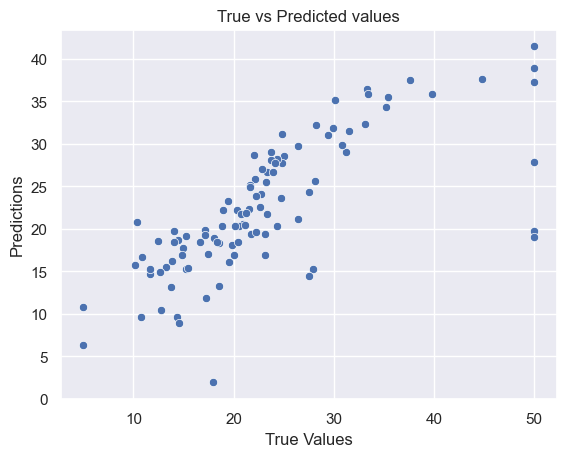

In [63]:
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted values')
plt.show()

In [41]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300, 500, 1000],
    'learning_rate': [0.5, 0.1, 0.01, 0.001, 0.0001],
    'max_depth': [1, 3, 5, 7, 9]
}

In [42]:
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(), 
    param_grid=param_grid, cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
    )

In [43]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.5, 0.1, 0.01, 0.001, 0.0001],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [50, 100, 150, 200, 300, 500, 1000]},
             scoring='neg_mean_squared_error')

In [44]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}

In [51]:
gradient_regression = Pipeline([
    ('preprocessing', preprocessing),
    ('gbr', GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=200))
])

In [52]:
gradient_regression.fit(X_train, y_train)

INFO:__main__:Handling Outliers From Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object') Column(s) From DataFrame
INFO:__main__:Handling Outliers Complited
INFO:__main__:Standardizing columns: Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object')
INFO:__main__:Standardization completed


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('outliers',
                                  <__main__.HandlingOutliers object at 0x000001CF2D2F7790>),
                                 ('scaler',
                                  <__main__.Standardization object at 0x000001CF2CC24850>)])),
                ('gbr', GradientBoostingRegressor(n_estimators=200))])

In [53]:
y_pred = gradient_regression.predict(X_test)

INFO:__main__:Handling Outliers From Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object') Column(s) From DataFrame
INFO:__main__:Handling Outliers Complited
INFO:__main__:Standardizing columns: Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object')
INFO:__main__:Standardization completed


In [58]:
evaluate_regression_model(y_test, y_pred)

,MAE,MSE,RMSE,R2,Adjusted R2
0,3.010143,18.573549,4.309704,0.806105,0.804146


In [49]:
residuals = y_test - y_pred

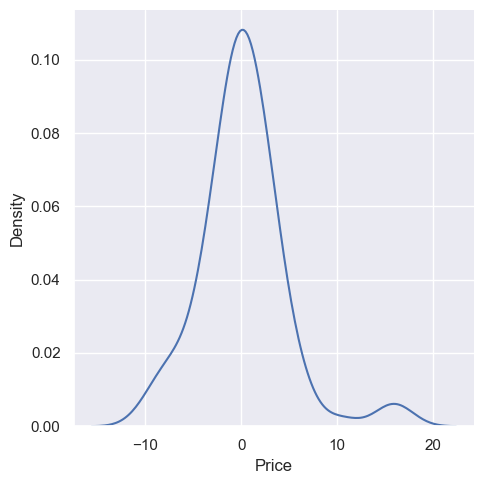

In [50]:
sns.displot(residuals, kind='kde')

In [70]:
df.head(10).Price

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
5    28.7
6    22.9
7    27.1
8    16.5
9    18.9
Name: Price, dtype: float64

In [69]:
test = df.head(10).drop(columns='Price')

gradient_regression.predict(test)

INFO:__main__:Handling Outliers From Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object') Column(s) From DataFrame
INFO:__main__:Handling Outliers Complited
INFO:__main__:Standardizing columns: Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object')
INFO:__main__:Standardization completed


array([35.59736521, 17.5348059 , 31.4730512 , 31.01569792, 30.52728944,
       22.8881138 , 21.37436396, 18.86864128, 14.41767231, 15.70458747])

In [71]:
X,y = df.drop(columns='Price'), df.Price

X = preprocessing.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

INFO:__main__:Handling Outliers From Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object') Column(s) From DataFrame
INFO:__main__:Handling Outliers Complited
INFO:__main__:Standardizing columns: Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object')
INFO:__main__:Standardization completed


In [78]:
rf_param_grid = {
    'n_estimators': [50, 100, 150, 200, 300, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [79]:
rf_grid_search = GridSearchCV(
    estimator=RandomForestRegressor(n_jobs=-1), 
    param_grid=rf_param_grid, cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
    )

In [80]:
rf_grid_search.fit(X_train, y_train)

c:\Users\Saif\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
3780 fits failed out of a total of 11340.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2357 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Saif\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Saif\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Saif\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150, 200, 300, 500, 1000]},
             scoring='neg_mean_squared_error')

In [81]:
rf_grid_search.best_params_

{'bootstrap': False,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [82]:
X,y = df.drop(columns='Price'), df.Price


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [83]:
random_forest_regression = Pipeline([
    ('preprocessing', preprocessing),
    ('gbr', RandomForestRegressor(bootstrap=False, 
                                  max_depth=30, 
                                  max_features='sqrt', 
                                  min_samples_leaf=1, 
                                  min_samples_split=2, 
                                  n_estimators=100, 
                                  n_jobs=-1))
])

In [84]:
random_forest_regression.fit(X_train, y_train)

INFO:__main__:Handling Outliers From Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object') Column(s) From DataFrame
INFO:__main__:Handling Outliers Complited
INFO:__main__:Standardizing columns: Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object')
INFO:__main__:Standardization completed


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('outliers',
                                  <__main__.HandlingOutliers object at 0x000001CF2D2F7790>),
                                 ('scaler',
                                  <__main__.Standardization object at 0x000001CF2CC24850>)])),
                ('gbr',
                 RandomForestRegressor(bootstrap=False, max_depth=30,
                                       max_features='sqrt', n_jobs=-1))])

In [85]:
y_pred = random_forest_regression.predict(X_test)

INFO:__main__:Handling Outliers From Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object') Column(s) From DataFrame
INFO:__main__:Handling Outliers Complited
INFO:__main__:Standardizing columns: Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat'],
      dtype='object')
INFO:__main__:Standardization completed


In [86]:
evaluate_regression_model(y_test, y_pred)

,MAE,MSE,RMSE,R2,Adjusted R2
0,3.119282,24.179187,4.917234,0.747586,0.745036


In [87]:
import pickle
# Serialize the model to a file
with open('house_price_pred_model.pkl', 'wb') as file:
    pickle.dump(gradient_regression, file)

In [89]:
# Deserialize the model from the file
with open('house_price_pred_model.pkl', 'rb') as file:
    regression_model = pickle.load(file)